# **CS345 Final Project: Using a Convolutional Neural Network for Skin Lesion Images for Melanoma Classification**

## Group Members: Cole Harris (No Team Members)

## Date: December 8, 2022

# **1. Introduction**

Utilizing machine learning technologies in health care diagnosis’s is a growing field and this notebook focus's specifically on the diagnosis of skin cancer and the skin cancer types based on pictures of the skin abnormality.

The interest towards this project is the interest of learning about the field of using machine learning for medical diagnosis. More specifically the use of machine learning in the health care industry is promising to help aid the healthcare professionals in treating patients and more so improving the health care outcomes of patients. Specifically, the interest in skin cancer is because melanoma is one of the most treatable cancers when caught at early stages (source: https://www.medicalnewstoday.com/articles/322700#melanoma). Many people also increase their likely hood of developing skin cancer because of previous sun burns. 

The dream is to have a technology in the hands of consumers/patients that can help with identifying melanoma and help get patients in contact with doctors to confirm the diagnosis and treat the patient

## **Introduction to the Data**
The data utilized for this notebook is sourced from Kaggle, from the following URL:

> https://www.kaggle.com/datasets/andrewmvd/isic-2019

The data set contains 25,331 images of skin lesions that fall in the following nine categories:


*   Melanoma
*   Melanocytic nevus
*   Basal cell carcinoma
*   Actinic keratosis
*   Benign keratosis
*   Dermatofibroma
*   Vascular Lesion
*   Squamous cell carcinoma
*   None of the Above



# **2. Notebook Model Setup**

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
import tensorflow as tf

Verify the version of tensorflow being used.

In [2]:
print(tf.__version__)

2.9.2


See if colab is connected to a gpu to improve runtime speed.

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

Mount Colab notebook to google drive to help in the saving of model weights and data and to allow for the uploading of model weights and data.

In [23]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


If the data from the Kaggle dataset has already been downloaded (and possibly cleansed) the data can be saved to the following file below. The following cell then uploads that data from your google drive for use.

In [24]:
! cp -r /content/gdrive/MyDrive/CS345Final/data .

# **3. Setup Kaggle Dataset**

First the kaggle api library is installed and setup with the API token by downloading the .json file from your computer. The .json file is optained from a valid kaggle account. For information on how to setup the kaggle api, go to this site: https://www.kaggle.com/docs/api

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


Below the skin lesion image dataset is download to the google colab project directory.

In [2]:
! kaggle datasets download -d andrewmvd/isic-2019

100% 9.10G/9.10G [08:00<00:00, 22.3MB/s]
100% 9.10G/9.10G [08:00<00:00, 20.3MB/s]


If there was an issue with the download or the data in the data file needs to be deleted and re downloaded. Run the following cell to delete all data in the data folder. **If you do not need to delete the data, skip to the next cell to unzip the data file.**

In [ ]:
import shutil
shutil.rmtree('data')

Below the skin lesion data .zip is unzipped to the folder named "data"

In [3]:
import zipfile
zipped_file = "isic-2019.zip"
target_directory = "data"
zfile = zipfile.ZipFile(zipped_file)
zfile.extractall(target_directory)

# **4. Image Information and Example**

Below in the unzipped folder for the image data, the number of images is counted. The result confirms that 25,331 skin lesions images were downloaded.

In [4]:
import pathlib
image_directory = "/content/data/ISIC_2019_Training_Input/ISIC_2019_Training_Input/"
data_dir = pathlib.Path(image_directory)

In [5]:
image_count = len(list(data_dir.glob('*.jpg')))
print("Total Skin Lesion Images: ", image_count)

Total Skin Lesion Images:  25331


Below displays an example image of a skin lesion image. The image is Image "ISIC_0073149.jpg" which displays an example of **Basal cell carcinoma**.

/content/data/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0073149.jpg
Example Skin Lesion Image: 


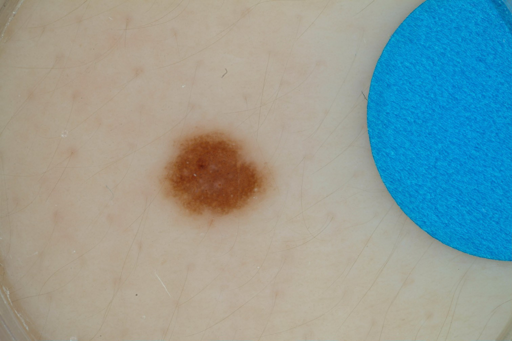

In [18]:
lesions = list(data_dir.glob('*.jpg'))
example_image = PIL.Image.open(str(lesions[13]))
print(str(lesions[5]))
#Resizing image to view better in Jupyter Notebook
width, height = example_image.size
resize_image = example_image.resize((width//2, height//2))
print("Example Skin Lesion Image: ")
resize_image

The skin lesion data comes with a metadata dataset to aid in the modeling of the skin lesion images. The metatdata is **not** used in this notebooks model. The metadata for reference is displayed below.

In [ ]:
feature_data_file = "/content/data/ISIC_2019_Training_Metadata.csv"
feature_data = pd.read_csv(feature_data_file)
feature_data

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male
...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female


The skin lesion dataset labels comes as a hot encoded table. The image labels corespond to the following classifications:

*   AK = Actinic Keratosis
*   BCC = Basal Cell Carcinoma
*   BKL = Benign Keratosis
*   DF = Dermatofibroma
*   MEL = Melanoma
*   NV = Menocytic Nevus
*   SCC = Squamous Cell Carcinoma
*   VASC = Vascular Lesion
*   UNK = None of the Above

The following table displays the label data.


In [20]:
label_data_file = "/content/data/ISIC_2019_Training_GroundTruth.csv"
label_data = pd.read_csv(label_data_file)
label_data

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **5. Preprocessing Images**

The following function moves all images to their corresponding classifcation folders based on the corresponding label in the label data table. The reason for this is to ease the process of using the data in the tensorflow. The function [tf.keras.utils.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) is used to preprocess the images. By pointing this function to the directory where the image folders are located, the function automatically splits the images into a testing and training dataset as well classifies each image based on the folder the image was located in.

In [ ]:
npLabeldata = pd.DataFrame(label_data).to_numpy()
def imgSort(img_dir,filepath):
    old_file = filepath.__str__()
    img_id = old_file[len(img_dir):-4]
    img_row = npLabeldata[np.argwhere(npLabeldata == img_id)[0,0]]
    folder = ""
    if img_row[1] == 1:
        folder = "MEL/"
    elif img_row[2] == 1:
        folder = "NV/"
    elif img_row[3] == 1:
        folder = "BCC/"
    elif img_row[4] == 1:
        folder = "AK/"
    elif img_row[5] == 1:
        folder = "BKL/"
    elif img_row[6] == 1:
        folder = "DF/"
    elif img_row[7] == 1:
        folder = "VASC/"
    elif img_row[8] == 1:
        folder = "SCC/"
    elif img_row[9] == 1:
        folder = "UNK/"
    else:
        print("File: ", filepath.__str__(), " id was not found in label dataset.")
        return None
    new_file = old_file[0:len(img_dir)] + folder + img_id + ".jpg"
    new_file = new_file.replace("\\", "/")
    new_folder = old_file[0:len(img_dir)] + folder
    new_folder = new_folder.replace("\\", "/")
    if not os.path.exists(new_folder):
        os.mkdir(new_folder)
    os.replace(old_file.replace("\\", "/"), new_file)
    

### 5.1 Move images

**NOTE: This should only be ran once. Running twice will result in an error because the images therefore have already been sorted to their corresponding folder. If this needs to be ran again, delete the data in the data folder(infomration on how to delete is listed above in the Setup Kaggle Dataset section) and proceeed to unzip the data again.**

In [ ]:
#Move all images to their coresponding folder to make fitting data to tensorflow easier
from tqdm import tqdm
for i in tqdm(range(len(lesions))):
    imgSort(image_directory, lesions[i])

100%|██████████| 25331/25331 [02:18<00:00, 182.98it/s]


As can be seen after the image moving is complete, there is not an "UNK" folder. This is because the data does not contain any images designated as UNK. According to the kaggle dataset this is a classification, therefore the model is built based on having a UNK class. The following cell creates a UNK folder.

In [ ]:
#Data does not contain a UNK Label
UNK_dir = image_directory + "UNK"
if not os.path.exists(UNK_dir):
    os.mkdir(UNK_dir)

The following cell places an array of lesion file locations into a dictionary that sorts based on the classification. This helps with displaying the image data in the next couple slides.

In [ ]:
def fileIMGs(lesion_dict, folder):
    img_dir = image_directory + folder
    img_dir = pathlib.Path(img_dir)
    lesion_dict[folder] = list(img_dir.glob('*'))

### 5.2 Example images of all Classifications

The follow cell displays an example image of all classifications except for the UNK class because the dataset does not contain a UNK classified image.

Actinic keratosis (Dataset Label = AK ) image:


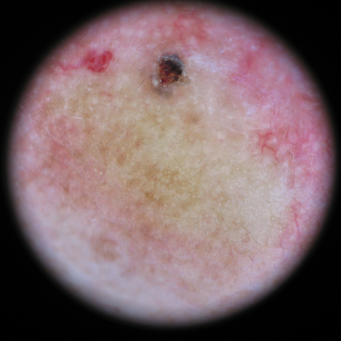

Basal Cell Carcinoma (Dataset Label = BCC ) image:


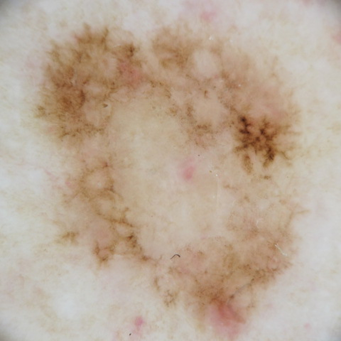

Benign Keratosis (Dataset Label = BKL ) image:


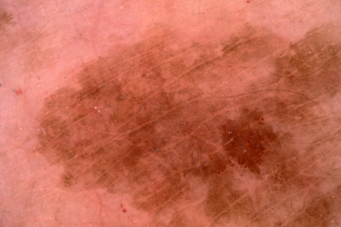

Dermatofibroma (Dataset Label = DF ) image:


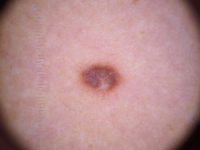

Melanoma (Dataset Label = MEL ) image:


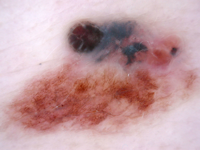

Melanocytic Nevus (Dataset Label = NV ) image:


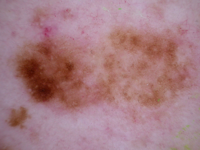

Squamous Cell Carcinoma (Dataset Label = SCC ) image:


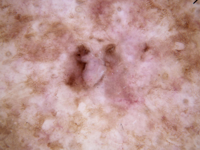

Vascular Lesion (Dataset Label = VASC ) image:


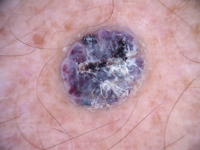

In [ ]:
#Display All types of Skin Cancer Lesions
skin_image_names = ["Actinic keratosis", "Basal Cell Carcinoma",
          "Benign Keratosis", "Dermatofibroma", 
          "Melanoma", "Melanocytic Nevus", 
          "Squamous Cell Carcinoma", "Vascular Lesion"]
directories = os.listdir(image_directory)
directories.sort()

#Get dictionary of image file locations
sorted_lesions = {}
#Reading images into new folders to display data
for folder in os.listdir(image_directory):
    fileIMGs(sorted_lesions, folder)

#No image data for UNK and remove .txt files
directories.remove('UNK')
directories.remove('LICENSE.txt')
directories.remove('ATTRIBUTION.txt')

for i in range(len(directories)):
    print(skin_image_names[i], "(Dataset Label =", directories[i], ") image:")
    img = PIL.Image.open(str(sorted_lesions[directories[i]][0]))
    w, h = img.size
    resize_img = img.resize((w//3, h//3))
    display(resize_img)

### 5.3 Filtering Images based on Image Size

As can be seen in the previous cell, the images are of varying size. The following function will display the different image sizes contained in the image data set.

In [ ]:
from tqdm import tqdm
def imageSizeData(sorted_lesions):
    dimensions= {}
    for key in tqdm(sorted_lesions):
        for imgs in sorted_lesions[key]:
            img = PIL.Image.open(str(imgs))
            w, h = img.size
            dim = str(w) + "x"+ str(h)
            if not dim in dimensions:
                dimensions[dim] = {"Total":1, key:1}
            else:
                if not key in dimensions[dim]:
                    dimensions[dim][key] = 1
                else:
                    dimensions[dim][key] += 1
                dimensions[dim]["Total"] += 1
    print("Total different image sizes =", len(dimensions))   
    print("Dim     | qty")
    for key in dimensions:
        print(str(key) + " | " + str(dimensions[key]))

After running the below cell. There are 101 different image sizes. But there are four image sizes that are most common: 

*   600x450: 10,015 Total Images
*   1024x1024: 12,414 Total Images
*   1024x680: 1,121 Total Images
*   1024x768: 774 Total Images

Nailing it down further only the 600x450 and 1024x1024 dimensions contain images from all classifications.

In [ ]:
imageSizeData(sorted_lesions)

100%|██████████| 11/11 [00:29<00:00,  2.70s/it]

Total different image sizes = 101
Dim     | qty
1024x1024 | {'Total': 12414, 'AK': 737, 'NV': 4206, 'MEL': 2858, 'SCC': 431, 'DF': 124, 'BKL': 1138, 'VASC': 111, 'BCC': 2809}
600x450 | {'Total': 10015, 'AK': 130, 'NV': 6705, 'MEL': 1113, 'SCC': 197, 'DF': 115, 'BKL': 1099, 'VASC': 142, 'BCC': 514}
1024x680 | {'Total': 1121, 'NV': 659, 'MEL': 229, 'BKL': 233}
1024x768 | {'Total': 774, 'NV': 598, 'MEL': 175, 'BKL': 1}
1024x685 | {'Total': 156, 'NV': 100, 'MEL': 16, 'BKL': 40}
1024x686 | {'Total': 17, 'NV': 14, 'MEL': 1, 'BKL': 2}
919x802 | {'Total': 54, 'NV': 42, 'MEL': 12}
576x768 | {'Total': 5, 'NV': 5}
1024x678 | {'Total': 21, 'NV': 18, 'MEL': 2, 'BKL': 1}
1024x682 | {'Total': 173, 'NV': 155, 'MEL': 10, 'BKL': 8}
1024x681 | {'Total': 78, 'NV': 56, 'MEL': 16, 'BKL': 6}
1024x679 | {'Total': 68, 'NV': 52, 'MEL': 11, 'BKL': 5}
1024x683 | {'Total': 40, 'NV': 31, 'MEL': 6, 'BKL': 3}
1024x684 | {'Total': 36, 'NV': 24, 'MEL': 9, 'BKL': 3}
1024x677 | {'Total': 33, 'NV': 23, 'MEL': 9, 'BKL': 1}

### 5.4 Delete all images that are not size 1024 x 1024

From the above data the 1024 x 1024 image dimension contains the most images out of all image sizes in the dataset. This image dimension contains 12,414 different images which comprises of approximately 49% of the data set. This size also had a better spread of images for all of the classes.

With this information, to make modeling the data easier and rescaling the photos more predictable, the choice was made to only use the 1024 x 1024 size images. Therefore the following cell deletes all images in the dataset that are not size 1024 x 1024.

In [ ]:
from tqdm import tqdm
equal = 0
nonequal = 0
for key in tqdm(sorted_lesions):
    for imgs in sorted_lesions[key]:
        img = PIL.Image.open(str(imgs))
        w, h = img.size
        img.close()
        if w != 1024 or h != 1024:
            os.remove(imgs)

100%|██████████| 11/11 [00:02<00:00,  5.19it/s]


The following cell verifies now that there is only 1 image size in the dataset which is 1024 x 1024.

In [ ]:
updated_sorted_lesions = {}
#Reading images into new folders to display data
for folder in os.listdir(image_directory):
    fileIMGs(updated_sorted_lesions, folder)
imageSizeData(updated_sorted_lesions)

100%|██████████| 11/11 [00:00<00:00, 15.71it/s]

Total different image sizes = 1
Dim     | qty
1024x1024 | {'Total': 12414, 'AK': 737, 'NV': 4206, 'MEL': 2858, 'SCC': 431, 'DF': 124, 'BKL': 1138, 'VASC': 111, 'BCC': 2809}


Once the data is cleaned and above it has been proven that the correct images are included, the image dataset can then be pushed to the google drive so that the image preprocessing is not lost.

In [ ]:
! cp -r data "/content/gdrive/MyDrive/CS345Final"

# **6. Convolutional Neural Network Modeling**

As stated above, the tf.keras.utils.image_dataset_from_directory() is utilized to preprocess the images and split the data into a training and testing dataset. The function returns a tf.data.Dataset. This tensor dataset is required for the tensorflow.keras layers to fit the model and test the models.

The following cell provides a function to split the data into a training and testing data sets. Each time this function is called the same split is made because a seed of 5 is input. This helps standarize the testing of each different model outlined below. Additionally this function has a shuffle parameter thats default is set to true. This guarentees that the data is shuffled before it is split so that all classes are represented in the training and testing data sets.

In [25]:
#Read image data
def splitImageData(data_dir, image_width, image_height, validation_split):
  training_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            image_size = (image_height,image_width),
                                                            seed = 5,
                                                            validation_split = validation_split,
                                                            subset = 'training'
                                                            )
  testing_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            image_size = (image_height,image_width),
                                                            seed = 5,
                                                            validation_split = validation_split,
                                                            subset = 'validation'
                                                            )
  return training_ds, testing_ds

### 6.1 Basic Neural Network Model as Baseline

Below data is split at a 0.3 validation split for the basic neural network model. In this example the images are resized to 512 x 512 to make modeling quicker.

In [ ]:
base_training_ds, base_testing_ds = splitImageData(data_dir, 1024//2, 1024//2, 0.3)

Found 12414 files belonging to 9 classes.
Using 8690 files for training.
Found 12414 files belonging to 9 classes.
Using 3724 files for validation.


Below is a confirmation that the image_dataset_from_directory() function detected the correct classifcations for the images based on the directory folder names.

In [ ]:
base_training_ds.class_names

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'UNK', 'VASC']

#### 6.1.1 Basic Neural Network Initial Setup

First a basic neural network is developed to act as a baseline for the upcoming convolutional neural networks (CNN). In this network the following layers are used:
1.   Rescaling layer: Rescales image array to [-1,1]. Found this rescaling in initial testing to produce better accuracy than rescaling to [0,1].
2.   Flatten Layer: Flattens the (512,512,3) tensor to single dimensional vector of size 512 * 512 * 3 = 786,432.
3. Dense Layer: A traditional neural netowrk layer with 128 units. Outputs a single dimensional vector of size 128.
4. Dense Layer: Last dense layer to output prediction of the neural network. Has 9 units because there are 9 classifications.

Once the model is built the model then needs to be compiled for tensorflow. The optimizer used is "adam" which is the most common optimizer and is a "stochastic gradient descent method". The compiler also calculates the loss using the SParseCategoricalCrossentropy function which calculates the loss for a multi class classification. This function is used because the image_dataset_from_directory() function provides labels as an integer instead of a one-hot encoded matrix.

In [ ]:
base_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./127.5, offset=-1),
    tf.keras.layers.Flatten(input_shape=(1024//2,1024//2,3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(9)
])

base_model.compile(optimizer='adam',
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

In [ ]:
hist_basic = base_model.fit(
  base_training_ds,
  validation_data=base_testing_ds,
  epochs=20
)

Epoch 1/20
272/272 [==============================] - 399s 1s/step - loss: 79.8784 - accuracy: 0.3250 - val_loss: 25.1640 - val_accuracy: 0.3402
Epoch 2/20
272/272 [==============================] - 374s 1s/step - loss: 18.3121 - accuracy: 0.3345 - val_loss: 19.9512 - val_accuracy: 0.3230
Epoch 3/20
272/272 [==============================] - 379s 1s/step - loss: 11.8806 - accuracy: 0.3311 - val_loss: 20.7179 - val_accuracy: 0.3561
Epoch 4/20
272/272 [==============================] - 373s 1s/step - loss: 9.6036 - accuracy: 0.3536 - val_loss: 16.5369 - val_accuracy: 0.3550
Epoch 5/20
272/272 [==============================] - 376s 1s/step - loss: 9.2008 - accuracy: 0.3590 - val_loss: 23.9139 - val_accuracy: 0.3520
Epoch 6/20
272/272 [==============================] - 377s 1s/step - loss: 9.8192 - accuracy: 0.3564 - val_loss: 12.4347 - val_accuracy: 0.3652
Epoch 7/20
272/272 [==============================] - 373s 1s/step - loss: 7.6988 - accuracy: 0.3526 - val_loss: 11.9670 - val_accura

Tensorflow provides a summary() method to visualize the layers and what the model is doing. Below is the summary of the base neural network model.

In [ ]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 512, 512, 3)       0         
                                                                 
 flatten (Flatten)           (None, 786432)            0         
                                                                 
 dense (Dense)               (None, 128)               100663424 
                                                                 
 dense_1 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 100,664,585
Trainable params: 100,664,585
Non-trainable params: 0
_________________________________________________________________


The following function was taken from the https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/ keras documentation. This function helps ease the graphing of the accuracies for the training and valdiation datasets.

In [14]:
#Function copied from keras.io: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

#### 6.1.2 Base Neural Network Results
As seen below the simple baseline neural network model produces lousy accuracy with the max accuracy in the validation test set to be around 36%. Interestingly the model hardly improved accuracy even with a total of 20 epochs. 

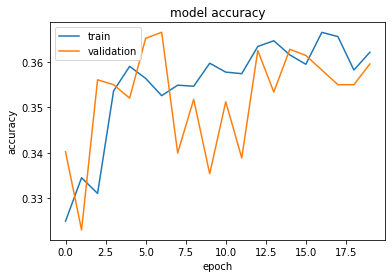

In [ ]:
plot_hist(hist_basic)

Saving the results of the base neural network so that the weights are not lost.

In [ ]:
base_model.save("BaseLineModel")
! cp -r BaseLineModel "/content/gdrive/MyDrive/CS345Final/SavedModels"

### 6.2 Basic Convolutional Neural Network

This base convolutional model rescales the input images to a 128 x 128 size. The reason for this was to see the accuracy of a rescaled image and to significantly reduce the number of parameters that are trained in the model.

In [ ]:
training_ds, testing_ds = splitImageData(data_dir, 1024//8, 1024//8, 0.3)

Found 12414 files belonging to 9 classes.
Using 8690 files for training.
Found 12414 files belonging to 9 classes.
Using 3724 files for validation.


#### 6.2.1 Basic Convolutional Neural Network Setup

Below a basic convolutional neural network is produced. This model is produced using the following layers in order:

1.   Rescaling Layer: This layer standardizes the image array to values between [-1, 1].
2.   Conv2D Layer: This is the first convolutional layer. This layer has the lowest filter value of 16. This is a basic convolution that has a kernel size of (3,3). By default the convolution has a stride of 1 and there is not padding. The convolution means for every (3x3) matrix in the image it is mutliplied by the (3x3) kernel. Then the 3x3 move 1 column or 1 row down and does the same convolution multiplication to the kernel. Lastly the activation function used is "relu".
3.   MaxPooling2D Layer: This max pooling layer takes the convolutional tensor and then finds the max value in every (2x2) matrix in the tensor. This is seen in the summary where the MaxPooling2D takes a tensor of size (126, 126, 16) and outputs a tensor of (63, 63, 16).
4.   Conv2D Layer: Same as the first convolutional layer except this time the filter is increased to 32.
5.   MaxPooling2d Layer: Same as the above max pooling layer.
6.   Conv2D layer: Same as the second convolutional layer.
7.   Flatten Layer: This layer takes the output of the last convolutional layer and then converts that to a single dimensional vector to be fed to the first Dense layer.
8.   Dense Layer: This layer is a traditional neural network layer. The units for this layer is set to 32. This means the layer outputs a single dimensional vector of size 32. This is the first layer used to classify the image input from the convolutions and pooling and flattening layers.
9.   Dense layer: This is the last layer in the model and has a units set to 9. The reason this layer is set to 9 is because the model has 9 different classifications as displayed above. This last layer produces a single dimensional vector of size 9 representing the models prediction.

The model is compiled using the same format as the base neural network above.







In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Rescaling(1./127.5, offset=-1))
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(9))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

This base convolutional model was trained and tested with 10 epochs.

In [ ]:
hist_base = model.fit(
  training_ds,
  validation_data=testing_ds,
  epochs=10
)

Epoch 1/10
272/272 [==============================] - 138s 474ms/step - loss: 1.4494 - accuracy: 0.4769 - val_loss: 1.3533 - val_accuracy: 0.4973
Epoch 2/10
272/272 [==============================] - 122s 440ms/step - loss: 1.3130 - accuracy: 0.5230 - val_loss: 1.3041 - val_accuracy: 0.5293
Epoch 3/10
272/272 [==============================] - 117s 421ms/step - loss: 1.2251 - accuracy: 0.5590 - val_loss: 1.2681 - val_accuracy: 0.5432
Epoch 4/10
272/272 [==============================] - 118s 425ms/step - loss: 1.1180 - accuracy: 0.5933 - val_loss: 1.2758 - val_accuracy: 0.5448
Epoch 5/10
272/272 [==============================] - 119s 427ms/step - loss: 0.9837 - accuracy: 0.6405 - val_loss: 1.3026 - val_accuracy: 0.5379
Epoch 6/10
272/272 [==============================] - 129s 466ms/step - loss: 0.8238 - accuracy: 0.7026 - val_loss: 1.4697 - val_accuracy: 0.5250
Epoch 7/10
272/272 [==============================] - 118s 426ms/step - loss: 0.6464 - accuracy: 0.7709 - val_loss: 1.5942 -

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)       

#### 6.2.2 Basic Convolutional Neural Network Results
As can be seen in the below graph and the above epoch result table (cell before summary), the model is better at predicting the skin lesion but the max accuracy is only around 54%. Additionally, the graph produces a result that looks like significant over fitting with an accuracy for the trainning set rising to be much larger than the testing set.

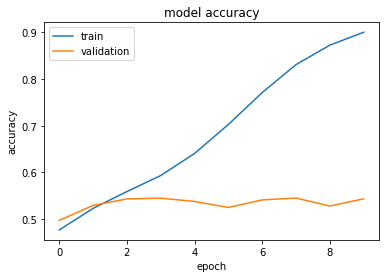

In [ ]:
plot_hist(hist_base)

### 6.3 Basic Convolutional Neural Network with Increased Filter and Unit Sizes

#### 6.3.1 Basic Convolutional Neural Network with Increase Filter and Unit Size Setup

The below model makes us of the same model structure as seen in section 6.2, but this time the filter and unit sizes were increased by a multiple of 2. 

In [ ]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Rescaling(1./127.5, offset=-1))
model2.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(64, activation='relu'))
model2.add(tf.keras.layers.Dense(9))

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
hist_base2 = model2.fit(
  training_ds,
  validation_data=testing_ds,
  epochs=10
)

Epoch 1/10
272/272 [==============================] - 124s 441ms/step - loss: 1.4545 - accuracy: 0.4687 - val_loss: 1.3682 - val_accuracy: 0.5024
Epoch 2/10
272/272 [==============================] - 122s 439ms/step - loss: 1.3287 - accuracy: 0.5206 - val_loss: 1.2793 - val_accuracy: 0.5430
Epoch 3/10
272/272 [==============================] - 117s 422ms/step - loss: 1.2512 - accuracy: 0.5448 - val_loss: 1.2634 - val_accuracy: 0.5357
Epoch 4/10
272/272 [==============================] - 119s 428ms/step - loss: 1.1663 - accuracy: 0.5811 - val_loss: 1.2462 - val_accuracy: 0.5521
Epoch 5/10
272/272 [==============================] - 119s 431ms/step - loss: 1.0577 - accuracy: 0.6168 - val_loss: 1.3551 - val_accuracy: 0.5330
Epoch 6/10
272/272 [==============================] - 124s 442ms/step - loss: 0.9108 - accuracy: 0.6779 - val_loss: 1.3774 - val_accuracy: 0.5403
Epoch 7/10
272/272 [==============================] - 127s 458ms/step - loss: 0.7356 - accuracy: 0.7386 - val_loss: 1.5599 -

The below model summary shows an increase in the output shape for all of the convolutional layers as well as for the pooling and dense layers. This increased the trainable parameters from 817, 481 to 3,268,233. 

In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 64)       

#### 6.3.2 Basic Convolutional Neural Network with Increase Filter and Unit Sizes Results

As seen in the below graph, the results for increasing the filter and unit sizes did not increase in the accuracy of the model and also showed significant over fitting. In fact the overfitting looked to be more significant with the increasing of filter and unit sizes.

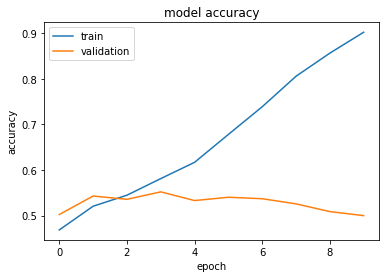

In [ ]:
plot_hist(hist_base2)

### 6.4 Basic Convolutional Neural Network with Increased Image Size

In the following model, the filter and unit size is decrease back to the values for the model in section 6.2 and the image size is doubled to 208x208. The same simple convolutional neural network model is used as seen in the previous two models. Same test split of 0.3 is used as well.

In [ ]:
training_ds3, testing_ds3 = splitImageData(data_dir, 1024//4, 1024//4, 0.3)

Found 12414 files belonging to 9 classes.
Using 8690 files for training.
Found 12414 files belonging to 9 classes.
Using 3724 files for validation.


#### 6.4.1 Basic Convolutional Neural Network with Increased Image Size Setup

In [ ]:
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.layers.Rescaling(1./127.5, offset=-1))
model3.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu'))
model3.add(tf.keras.layers.MaxPooling2D((2, 2)))
model3.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model3.add(tf.keras.layers.MaxPooling2D((2, 2)))
model3.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(32, activation='relu'))
model3.add(tf.keras.layers.Dense(9))

In [ ]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
hist_imgSizeIncrease = model3.fit(
  training_ds3,
  validation_data=testing_ds3,
  epochs=10
)

Epoch 1/10
272/272 [==============================] - 124s 439ms/step - loss: 1.5870 - accuracy: 0.4136 - val_loss: 1.3869 - val_accuracy: 0.4976
Epoch 2/10
272/272 [==============================] - 120s 434ms/step - loss: 1.4027 - accuracy: 0.4922 - val_loss: 1.3569 - val_accuracy: 0.5161
Epoch 3/10
272/272 [==============================] - 125s 451ms/step - loss: 1.3240 - accuracy: 0.5228 - val_loss: 1.2987 - val_accuracy: 0.5274
Epoch 4/10
272/272 [==============================] - 120s 435ms/step - loss: 1.2347 - accuracy: 0.5635 - val_loss: 1.3376 - val_accuracy: 0.5228
Epoch 5/10
272/272 [==============================] - 124s 447ms/step - loss: 1.1040 - accuracy: 0.6081 - val_loss: 1.5180 - val_accuracy: 0.5054
Epoch 6/10
272/272 [==============================] - 119s 430ms/step - loss: 0.9417 - accuracy: 0.6675 - val_loss: 1.6139 - val_accuracy: 0.4930
Epoch 7/10
272/272 [==============================] - 128s 461ms/step - loss: 0.7625 - accuracy: 0.7398 - val_loss: 2.0097 -

In [ ]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 32)       

#### 6.4.2 Basic Convolutional Neural Network with Increased Image Size Results

As can be seen in the following resulting graph, increasing the image size did not result in a better accuracy from the model. In fact this model performed the worst out of the last three models with a top validation accuracy of around 52% and significant overfitting continued to occur.

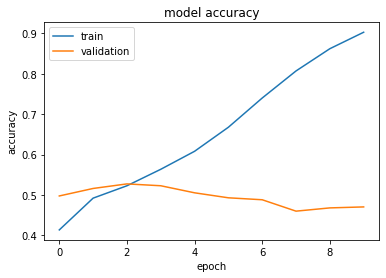

In [ ]:
plot_hist(hist_imgSizeIncrease)

In [ ]:
model3.save("SimpleConvModel3")
! cp -r SimpleConvModel3 "/content/gdrive/MyDrive/CS345Final/SavedModels"

# **7. Transfer Learning**

### 7.1 Transfer Learning using Xception

Below uses a traditional neural network technique called transfer learning. Transfer learning is using a pre-trained model that is proven to have good accuracy and applying that model's weights to the specified data set at hand. 

The below cell makes use of the Xception pre-trained model. The Xception weights used are the weights from the model training on the ImageNet dataset. The choice of using the Xception model is strictly based on the model being a popular model used for transfer learning.

One important task when performing transfer learning is to freeze all the weights in the Xception model. The reason for this is so that these pre-trained weights are not changed during the main training process. This is done in the following code: 
```
model.trainable = False
```
Once the Xception model weights are frozen, a few initial layers are added on top of the model. These layers are trained to make predictions based on an input from the Xception model.

The following model is based on the model example provided in the transfer learning documentation for the keras api.

In the following model a rescaling layer is added to ensure all values in the image are between [-1,1]. This rescaling layer is the only layer that happens before the Xception model. Next a Global Average Pooling layer is added. This performs a an average pooling operation on the images instead of a max pooling like what was used in the previous cells. Next a Dropout layer is added. This dropout helps reduce overfitting by randomly selecting neurons in the neural network to be excluded from the model in each step. Lastly the model adds a Dense layer which is a regular neural network layer. The dense layer has 9 outputs to represent the 9 different image classifications.

In [ ]:
from tensorflow.keras.applications import Xception
model = Xception(weights='imagenet', input_shape=(512,512,3), include_top=False)
#Freeze pretrained weigths
model.trainable = False
# Rebuild top
inputs = tf.keras.Input(shape=(512,512,3))
x = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)

x = model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(9)(x)
preTrainModel = tf.keras.Model(inputs, outputs)
preTrainModel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### 7.1.1 Transfer Learning Model Summary

The model summary is listed below. Here it can be seen the images are fed to the rescaling layer which then feeds to the xception model, which then feeds to the pooling, droput, and dense layers. Interestingly, it can be proved that the paramters for the xception were frozen, with param # for the xception matching the Non-trainable params number.

In [ ]:
preTrainModel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 512, 512, 3)       0         
                                                                 
 xception (Functional)       (None, 16, 16, 2048)      20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 9)                 18441     
                                                           

To reduce the number of parameters used but to not significantly change the images processed, the image size is rescaled to a size of 512 x 512. The image dataset just like the previous models, has a 0.3 test set split.

In [9]:
pretrain_trainds, pretrain_testds = splitImageData(data_dir, 1024//2, 1024//2, 0.3)

Found 12414 files belonging to 9 classes.
Using 8690 files for training.
Found 12414 files belonging to 9 classes.
Using 3724 files for validation.


The model was trained for an initial 15 epochs.

In [ ]:
hist_preTrain = preTrainModel.fit(
  pretrain_trainds,
  validation_data=pretrain_testds,
  epochs=15
)

Epoch 1/15
272/272 [==============================] - 315s 1s/step - loss: 1.4019 - accuracy: 0.4949 - val_loss: 1.2375 - val_accuracy: 0.5534
Epoch 2/15
272/272 [==============================] - 300s 1s/step - loss: 1.2358 - accuracy: 0.5591 - val_loss: 1.1719 - val_accuracy: 0.5752
Epoch 3/15
272/272 [==============================] - 300s 1s/step - loss: 1.1825 - accuracy: 0.5758 - val_loss: 1.1424 - val_accuracy: 0.5932
Epoch 4/15
272/272 [==============================] - 301s 1s/step - loss: 1.1463 - accuracy: 0.5890 - val_loss: 1.1448 - val_accuracy: 0.5827
Epoch 5/15
272/272 [==============================] - 301s 1s/step - loss: 1.1159 - accuracy: 0.6006 - val_loss: 1.1111 - val_accuracy: 0.6007
Epoch 6/15
272/272 [==============================] - 300s 1s/step - loss: 1.0949 - accuracy: 0.6041 - val_loss: 1.0926 - val_accuracy: 0.6055
Epoch 7/15
272/272 [==============================] - 300s 1s/step - loss: 1.0776 - accuracy: 0.6108 - val_loss: 1.0871 - val_accuracy: 0.6088

#### 7.1.2 Transfer Learning Initial Results

Below the graph can be seen to be increasing in accuracy for the training and validation sets quickly intially and then slows down significantly after about 4 epochs. The validation and testing accuracies don't show overfitting in the below image so the image weights are saved and then more training is performed.

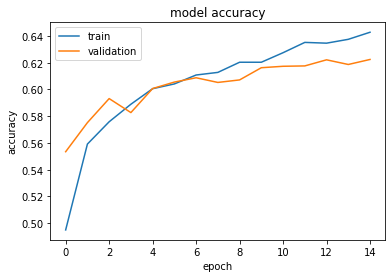

In [ ]:
plot_hist(hist_preTrain)

The initial transfer learning model and the model weights are saved to google drive so that it is not lost.

In [ ]:
! mkdir "/content/gdrive/MyDrive/CS345Final/SavedModels"
preTrainModel.save("Pre-Train_Model")
! cp -r Pre-Train_Model "/content/gdrive/MyDrive/CS345Final/SavedModels"

The model weights are loaded from the previous saved model and used in the next upcoming training cells.

In [ ]:
preTrainModelload = tf.keras.models.load_model('/content/gdrive/MyDrive/CS345Final/SavedModels/Pre-Train_Model')

Below the model is trained for 3 iterations of 5 epochs to see if the model accuracy will increase.

In [ ]:
hist_preTrainload = preTrainModelload.fit(
  pretrain_trainds,
  validation_data=pretrain_testds,
  epochs=5
)

Epoch 1/5
272/272 [==============================] - 324s 1s/step - loss: 0.9822 - accuracy: 0.6417 - val_loss: 1.0379 - val_accuracy: 0.6241
Epoch 2/5
272/272 [==============================] - 309s 1s/step - loss: 0.9704 - accuracy: 0.6450 - val_loss: 1.0298 - val_accuracy: 0.6267
Epoch 3/5
272/272 [==============================] - 309s 1s/step - loss: 0.9660 - accuracy: 0.6450 - val_loss: 1.0284 - val_accuracy: 0.6243
Epoch 4/5
272/272 [==============================] - 310s 1s/step - loss: 0.9577 - accuracy: 0.6518 - val_loss: 1.0436 - val_accuracy: 0.6216
Epoch 5/5
272/272 [==============================] - 309s 1s/step - loss: 0.9493 - accuracy: 0.6521 - val_loss: 1.0256 - val_accuracy: 0.6286


The initial 5 epochs shows a very small increase in accuracy for the testing set.

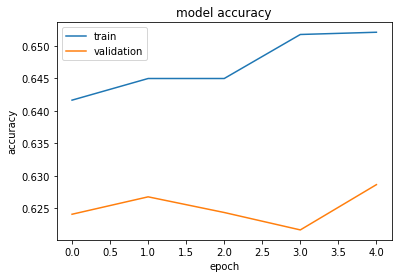

In [ ]:
plot_hist(hist_preTrainload)

In [ ]:
hist_preTrainload2 = preTrainModelload.fit(
  pretrain_trainds,
  validation_data=pretrain_testds,
  epochs=5
)

Epoch 1/5
272/272 [==============================] - 310s 1s/step - loss: 0.9506 - accuracy: 0.6547 - val_loss: 1.0256 - val_accuracy: 0.6257
Epoch 2/5
272/272 [==============================] - 309s 1s/step - loss: 0.9414 - accuracy: 0.6564 - val_loss: 1.0242 - val_accuracy: 0.6294
Epoch 3/5
272/272 [==============================] - 309s 1s/step - loss: 0.9389 - accuracy: 0.6565 - val_loss: 1.0207 - val_accuracy: 0.6302
Epoch 4/5
272/272 [==============================] - 309s 1s/step - loss: 0.9266 - accuracy: 0.6603 - val_loss: 1.0155 - val_accuracy: 0.6329
Epoch 5/5
272/272 [==============================] - 308s 1s/step - loss: 0.9280 - accuracy: 0.6634 - val_loss: 1.0163 - val_accuracy: 0.6308


The second iteration of 5 epochs shows a similar results with a small increase in validation accuracy.

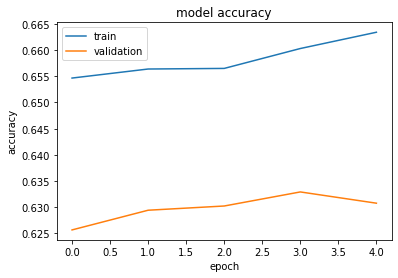

In [ ]:
plot_hist(hist_preTrainload2)

In [ ]:
hist_preTrainload3 = preTrainModelload.fit(
  pretrain_trainds,
  validation_data=pretrain_testds,
  epochs=5
)

Epoch 1/5
272/272 [==============================] - 310s 1s/step - loss: 0.9215 - accuracy: 0.6670 - val_loss: 1.0079 - val_accuracy: 0.6329
Epoch 2/5
272/272 [==============================] - 309s 1s/step - loss: 0.9231 - accuracy: 0.6624 - val_loss: 1.0094 - val_accuracy: 0.6329
Epoch 3/5
272/272 [==============================] - 309s 1s/step - loss: 0.9206 - accuracy: 0.6659 - val_loss: 1.0065 - val_accuracy: 0.6351
Epoch 4/5
272/272 [==============================] - 309s 1s/step - loss: 0.9175 - accuracy: 0.6636 - val_loss: 1.0151 - val_accuracy: 0.6332
Epoch 5/5
272/272 [==============================] - 308s 1s/step - loss: 0.9123 - accuracy: 0.6672 - val_loss: 1.0066 - val_accuracy: 0.6321


#### 7.1.3 Transfer Learning Final Results

This last iteration of epochs shows that the model training accuracy has stalled to be around 63%. This 63% has proven to be the most accurate result out of all the models in the notebook up to this point and is a little less than double the accuracy of the baseline neural network.

Fine tuning this model is not performed due to the model accuracy still only being around 63%. Fine tuning would involve unfreezing the xception weights and training the whole model at a very small learning rate. The risk of overfitting in this case is large and must be watched closely to prevent overfitting.

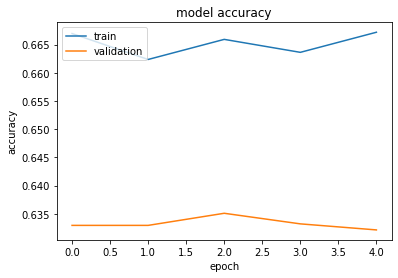

In [ ]:
plot_hist(hist_preTrainload3)

### 7.2 Transfer Learning With Image Augmentation

The below model makes use of the above pre-trained model structure but adds an image augmentation layer. The image augmentaton layer randomly flips or rotates images in the dataset before the image is fed to the neural network. The use of this image augmentaton helps with preventing overfitting of the model by providing unexpected images to the model.

In [ ]:
image_augment = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                    tf.keras.layers.RandomRotation(0.1),])

In [ ]:
from tensorflow.keras.applications import Xception
model = Xception(weights='imagenet', input_shape=(512,512,3), include_top=False)
#Freeze pretrained weigths
model.trainable = False
# Rebuild top
inputs = tf.keras.Input(shape=(512,512,3))
x = image_augment(inputs)
x = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(x)

x = model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(9)(x)
preTrainModel2 = tf.keras.Model(inputs, outputs)
preTrainModel2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

83683744/83683744 [==============================] - 1s 0us/step


#### 7.2.1 Transfer Learning with Image Augmentation Model Summary

In [ ]:
preTrainModel2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, 3)     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 512, 512, 3)       0         
                                                                 
 xception (Functional)       (None, 16, 16, 2048)      20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                           

#### 7.2.2 First 25 Epochs for Training

In [ ]:
hist_preTrain2 = preTrainModel2.fit(
  pretrain_trainds,
  validation_data=pretrain_testds,
  epochs=25
)

Epoch 1/25
272/272 [==============================] - 307s 1s/step - loss: 1.4080 - accuracy: 0.4924 - val_loss: 1.2439 - val_accuracy: 0.5481
Epoch 2/25
272/272 [==============================] - 288s 1s/step - loss: 1.2451 - accuracy: 0.5581 - val_loss: 1.1853 - val_accuracy: 0.5671
Epoch 3/25
272/272 [==============================] - 288s 1s/step - loss: 1.1949 - accuracy: 0.5715 - val_loss: 1.1593 - val_accuracy: 0.5811
Epoch 4/25
272/272 [==============================] - 290s 1s/step - loss: 1.1649 - accuracy: 0.5814 - val_loss: 1.1692 - val_accuracy: 0.5669
Epoch 5/25
272/272 [==============================] - 288s 1s/step - loss: 1.1382 - accuracy: 0.5899 - val_loss: 1.1306 - val_accuracy: 0.5849
Epoch 6/25
272/272 [==============================] - 289s 1s/step - loss: 1.1160 - accuracy: 0.5956 - val_loss: 1.1083 - val_accuracy: 0.6004
Epoch 7/25
272/272 [==============================] - 288s 1s/step - loss: 1.1045 - accuracy: 0.5940 - val_loss: 1.1069 - val_accuracy: 0.5969

#### 7.2.3 First 25 Epochs Results

As seen in the above table and below graph, the results for the validation test set close align with the results from the training test set. This is promising because this shows after about 25 epochs, there is not overfitting in the model. The model validation accuracy initally increases at a decent rate but around 6 the rate of increase of accuracy decreases and the model learns extremely slowly for the next around 20 epochs. 

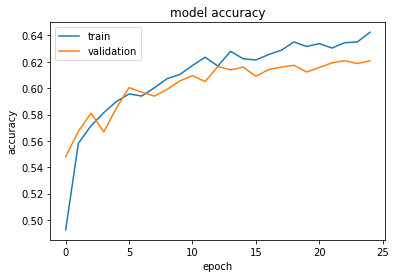

In [ ]:
plot_hist(hist_preTrain2)

Model weights are saved to google drive so that they are not lost.

In [ ]:
preTrainModel2.save("Pre-Train_Model_ImgAug")
! cp -r Pre-Train_Model_ImgAug "/content/gdrive/MyDrive/CS345Final/SavedModels"

#### 7.2.4 Second 25 Epochs for Training

In [ ]:
hist_preTrain2_secondTrain = preTrainModel2.fit(
  pretrain_trainds,
  validation_data=pretrain_testds,
  epochs=25
)

Epoch 1/25
272/272 [==============================] - 293s 1s/step - loss: 0.9880 - accuracy: 0.6367 - val_loss: 1.0419 - val_accuracy: 0.6219
Epoch 2/25
272/272 [==============================] - 296s 1s/step - loss: 0.9836 - accuracy: 0.6380 - val_loss: 1.0422 - val_accuracy: 0.6224
Epoch 3/25
272/272 [==============================] - 348s 1s/step - loss: 0.9953 - accuracy: 0.6356 - val_loss: 1.0584 - val_accuracy: 0.6168
Epoch 4/25
272/272 [==============================] - 293s 1s/step - loss: 0.9790 - accuracy: 0.6396 - val_loss: 1.0526 - val_accuracy: 0.6259
Epoch 5/25
272/272 [==============================] - 291s 1s/step - loss: 0.9811 - accuracy: 0.6422 - val_loss: 1.0447 - val_accuracy: 0.6165
Epoch 6/25
272/272 [==============================] - 292s 1s/step - loss: 0.9793 - accuracy: 0.6418 - val_loss: 1.0387 - val_accuracy: 0.6241
Epoch 7/25
272/272 [==============================] - 293s 1s/step - loss: 0.9744 - accuracy: 0.6470 - val_loss: 1.0284 - val_accuracy: 0.6259

#### 7.2.5 Second 25 Epochs Results

As what can be seen in the following graph, the transfer learning model did not improve the next 25 epochs and stalled at around 62-63% accuracy. This is not an improvement in accuracy in comparison to the transfer learning model found in section 7.1. What is promising from this result though is the image augmentation did a good job preventing overfitting with the training accuracy never increasing to a much larger value than the validation accuracy.

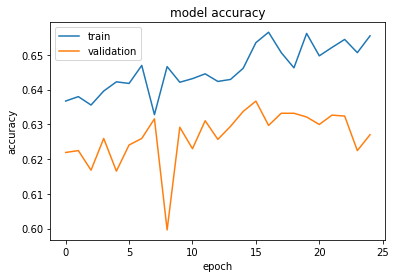

In [ ]:
plot_hist(hist_preTrain2_secondTrain)

The model weights are saved to google drive so that the trained weights are not lost.

In [ ]:
preTrainModel2.save("Pre-Train_Model_ImgAugSecondTrain")
! cp -r Pre-Train_Model_ImgAugSecondTrain "/content/gdrive/MyDrive/CS345Final/SavedModels"

### 7.3 Transfer Learning using VGG16

To see the result of a different model, transfer learning is performed utilizing VGG16 to see the difference using VGG16 plays in comparison to Xception. The following transfer learning is the same as the Xception model and utilizes a reduced input shape of 256x256. 

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet', input_shape=(1024//4,1024//4,3), include_top=False)
#Freeze pretrained weigths
model.trainable = False
# Rebuild top
inputs = tf.keras.Input(shape=(1024//4,1024//4,3))
x = image_augment(inputs)
x = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(x)

x = model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(9)(x)
vgg16Model = tf.keras.Model(inputs, outputs)
vgg16Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### 7.3.1 VGG16 Transfer Learning Model Summary

As can be seen in the following parameters, the VGG16 model utilizes much less parameters than the Xception model. This is intriguing because a resource exhausted error was produced when fine tuning was attempted on the previous Xception model. Using VGG16 and reducing the image size is an attempt to make fine tuning the model more feasible.

In [ ]:
vgg16Model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [26]:
vgg16_trainds, vgg16_testds = splitImageData(data_dir, 1024//4, 1024//4, 0.3)

Found 12414 files belonging to 9 classes.
Using 8690 files for training.
Found 12414 files belonging to 9 classes.
Using 3724 files for validation.


In [ ]:
hist_vgg16 = vgg16Model.fit(
  vgg16_trainds,
  validation_data=vgg16_testds,
  epochs=10
)

Epoch 1/10
272/272 [==============================] - 155s 516ms/step - loss: 1.6197 - accuracy: 0.3810 - val_loss: 1.4641 - val_accuracy: 0.4455
Epoch 2/10
272/272 [==============================] - 135s 489ms/step - loss: 1.4802 - accuracy: 0.4627 - val_loss: 1.4044 - val_accuracy: 0.4863
Epoch 3/10
272/272 [==============================] - 137s 494ms/step - loss: 1.4271 - accuracy: 0.4876 - val_loss: 1.3713 - val_accuracy: 0.5075
Epoch 4/10
272/272 [==============================] - 136s 492ms/step - loss: 1.4043 - accuracy: 0.4960 - val_loss: 1.3526 - val_accuracy: 0.5107
Epoch 5/10
272/272 [==============================] - 136s 491ms/step - loss: 1.3789 - accuracy: 0.5030 - val_loss: 1.3354 - val_accuracy: 0.5166
Epoch 6/10
272/272 [==============================] - 135s 487ms/step - loss: 1.3649 - accuracy: 0.5093 - val_loss: 1.3211 - val_accuracy: 0.5282
Epoch 7/10
272/272 [==============================] - 135s 488ms/step - loss: 1.3550 - accuracy: 0.5101 - val_loss: 1.3113 -

#### 7.3.2 VGG16 Transfer Learning Results

The following results show accuracies that are worse than the previous two transfer learning performed with the Xcpetion model. The previous Xception model, produced an accuracy of 60% after 10 epochs on the same dataset. This reduced accuracy may be because the VGG16 is not as good at providing proper inputs for the simple layers after VGG16 or it could be due to the fact that the image sizes were reduced. 

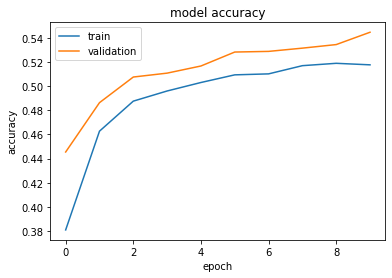

In [ ]:
plot_hist(hist_vgg16)

Saving the results of the transfer learning model so that the weights are not lost.

In [ ]:
vgg16Model.save("vgg16_Model")
! cp -r vgg16_Model "/content/gdrive/MyDrive/CS345Final/SavedModels"

In [ ]:
hist_vgg16_2 = vgg16Model.fit(
  vgg16_trainds,
  validation_data=vgg16_testds,
  epochs=10
)

Epoch 1/10
272/272 [==============================] - 137s 496ms/step - loss: 1.3240 - accuracy: 0.5216 - val_loss: 1.2820 - val_accuracy: 0.5368
Epoch 2/10
272/272 [==============================] - 137s 495ms/step - loss: 1.3139 - accuracy: 0.5220 - val_loss: 1.2790 - val_accuracy: 0.5365
Epoch 3/10
272/272 [==============================] - 144s 522ms/step - loss: 1.3115 - accuracy: 0.5215 - val_loss: 1.2724 - val_accuracy: 0.5405
Epoch 4/10
272/272 [==============================] - 141s 508ms/step - loss: 1.3045 - accuracy: 0.5214 - val_loss: 1.2688 - val_accuracy: 0.5363
Epoch 5/10
272/272 [==============================] - 138s 499ms/step - loss: 1.2985 - accuracy: 0.5300 - val_loss: 1.2639 - val_accuracy: 0.5448
Epoch 6/10
272/272 [==============================] - 137s 495ms/step - loss: 1.2958 - accuracy: 0.5255 - val_loss: 1.2642 - val_accuracy: 0.5373
Epoch 7/10
272/272 [==============================] - 137s 493ms/step - loss: 1.2941 - accuracy: 0.5307 - val_loss: 1.2553 -

After an additional 10 epochs the transfer learning CNN model with VGG16 hardly improved in accuracy. Interestingly, the transfer learning model using VGG16, is the only model in this notebook that produced validation accuracy that is larger than the training set accuracy. The next step is to then fine tune the model to see if that increases the accuracy of the model.

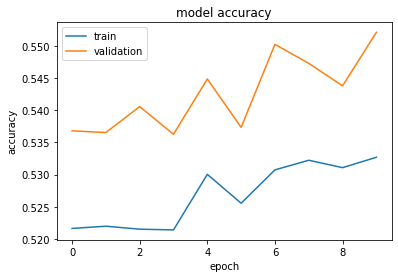

In [ ]:
plot_hist(hist_vgg16_2)

In [ ]:
vgg16Model.save("vgg16_Model_2")
! cp -r vgg16_Model_2 "/content/gdrive/MyDrive/CS345Final/SavedModels"

#### 7.3.3 VGG16 Fine Tuning

In [ ]:
vgg16_Model_load = tf.keras.models.load_model('/content/gdrive/MyDrive/CS345Final/SavedModels/vgg16_Model_2')

To fine tune the model, first the parameters in VGG16 must be unfrozen so that slight tweeks to these parameters can be performed to improve model performance.

In [ ]:
#UnFreeze pretrained weights in VGG16
for layer in vgg16_Model_load.layers:
  if layer.name == "vgg16":
    layer.trainable = True
vgg16_Model_load.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

When fine tuning, the learning rate used for the adam optimizer is a much smaller value. Below this can be seen as 1e-5. A small value is used to prevent completely changing the model weights that were trained previously in the VGG16 model as well as the weights trained in the previous 20 epochs.

In [ ]:
vgg16_Model_load.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

To help catch overfitting, the model is fitted to the data with the unfrozen weights for a first 5 epoch iteration.

In [ ]:
hist_VGG16FineTune = vgg16_Model_load.fit(
  vgg16_trainds,
  validation_data=vgg16_testds,
  epochs=5
)

Epoch 1/5
272/272 [==============================] - 217s 764ms/step - loss: 1.1854 - accuracy: 0.5703 - val_loss: 1.1219 - val_accuracy: 0.5926
Epoch 2/5
272/272 [==============================] - 210s 765ms/step - loss: 1.0737 - accuracy: 0.6132 - val_loss: 1.0028 - val_accuracy: 0.6504
Epoch 3/5
272/272 [==============================] - 214s 778ms/step - loss: 0.9944 - accuracy: 0.6432 - val_loss: 0.9430 - val_accuracy: 0.6660
Epoch 4/5
272/272 [==============================] - 216s 786ms/step - loss: 0.9269 - accuracy: 0.6697 - val_loss: 0.9769 - val_accuracy: 0.6582
Epoch 5/5
272/272 [==============================] - 215s 781ms/step - loss: 0.8739 - accuracy: 0.6864 - val_loss: 0.8888 - val_accuracy: 0.6890


#### 7.3.4 VGG16 Fine Tune Results 1

The results after the first 5 epochs for fine tuning are the most promising results. By fine tuning the simple model with VGG16 transfer learning, this produced accuracies that were the most accurate at 68%.

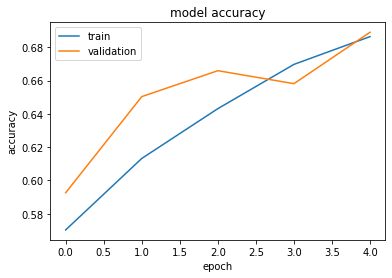

In [ ]:
plot_hist(hist_VGG16FineTune)

Saving first iteration of VGG16 fine tune weights.

In [ ]:
vgg16_Model_load.save("VGG16_FineTune0")
! cp -r VGG16_FineTune0 "/content/gdrive/MyDrive/CS345Final/SavedModels"

In [ ]:
hist_VGG16FineTune2 = vgg16_Model_load.fit(
  vgg16_trainds,
  validation_data=vgg16_testds,
  epochs=3
)

Epoch 1/3
272/272 [==============================] - 220s 798ms/step - loss: 0.8296 - accuracy: 0.7029 - val_loss: 0.8797 - val_accuracy: 0.6904
Epoch 2/3
272/272 [==============================] - 217s 790ms/step - loss: 0.7776 - accuracy: 0.7188 - val_loss: 0.8496 - val_accuracy: 0.7025
Epoch 3/3
272/272 [==============================] - 231s 839ms/step - loss: 0.7356 - accuracy: 0.7353 - val_loss: 0.8272 - val_accuracy: 0.7095


#### 7.3.4 VGG16 Fine Tune Results 2

After the second iteration of VGG16 fine tuning (3 epochs) the model continues to show promising learning of the datset. Althought at this time now the training set accuracy has surpassed the testing set accuracy. With this in mind, care has to be taken to continue fitting the model so that overfitting does not occur.

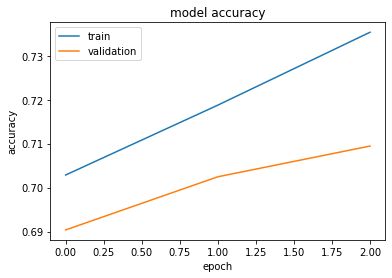

In [ ]:
plot_hist(hist_VGG16FineTune2)

In [ ]:
vgg16_Model_load.save("VGG16_FineTune1")
! cp -r VGG16_FineTune1 "/content/gdrive/MyDrive/CS345Final/SavedModels"

#### 7.3.5 Final VGG16 Fine Tuning

In [8]:
vgg16_Model_load = tf.keras.models.load_model('/content/gdrive/MyDrive/CS345Final/SavedModels/VGG16_FineTune1')

In [12]:
import shutil
name = 'VGG16_FineTune'

histsVGG16 = []
for i in range(2,7):
  inp = input("Continue Fine Tuning? y/n: ")
  if (inp == 'n'):
    break
  print("Iteration",i)
  hist = vgg16_Model_load.fit(
  vgg16_trainds,
  validation_data=vgg16_testds,
  epochs=3
  )
  histsVGG16.append(hist)
  folderName = name + str(i)
  vgg16_Model_load.save(folderName)
  src = "/content/" + folderName
  dest = "/content/gdrive/MyDrive/CS345Final/SavedModels/" + folderName
  shutil.copytree(src, dest)

Continue Fine Tuning? y/n: y
Iteration 2
Epoch 1/3
272/272 [==============================] - 238s 798ms/step - loss: 0.6819 - accuracy: 0.7542 - val_loss: 0.8518 - val_accuracy: 0.7038
Epoch 2/3
272/272 [==============================] - 218s 793ms/step - loss: 0.6433 - accuracy: 0.7671 - val_loss: 0.7966 - val_accuracy: 0.7226
Epoch 3/3
272/272 [==============================] - 215s 781ms/step - loss: 0.6108 - accuracy: 0.7749 - val_loss: 0.8049 - val_accuracy: 0.7285


Continue Fine Tuning? y/n: y
Iteration 3
Epoch 1/3
272/272 [==============================] - 223s 810ms/step - loss: 0.5692 - accuracy: 0.7924 - val_loss: 0.8152 - val_accuracy: 0.7296
Epoch 2/3
272/272 [==============================] - 217s 789ms/step - loss: 0.5395 - accuracy: 0.8061 - val_loss: 0.7794 - val_accuracy: 0.7347
Epoch 3/3
272/272 [==============================] - 213s 775ms/step - loss: 0.5012 - accuracy: 0.8199 - val_loss: 0.8510 - val_accuracy: 0.7146


Continue Fine Tuning? y/n: y
Iteration 4
Epoch 1/3
272/272 [==============================] - 216s 784ms/step - loss: 0.4812 - accuracy: 0.8319 - val_loss: 0.8684 - val_accuracy: 0.7264
Epoch 2/3
272/272 [==============================] - 216s 781ms/step - loss: 0.4652 - accuracy: 0.8334 - val_loss: 0.8078 - val_accuracy: 0.7422
Epoch 3/3
272/272 [==============================] - 214s 777ms/step - loss: 0.4212 - accuracy: 0.8483 - val_loss: 0.8201 - val_accuracy: 0.7376


Continue Fine Tuning? y/n: y
Iteration 5
Epoch 1/3
272/272 [==============================] - 218s 791ms/step - loss: 0.4041 - accuracy: 0.8550 - val_loss: 0.8438 - val_accuracy: 0.7334
Epoch 2/3
272/272 [==============================] - 216s 785ms/step - loss: 0.3743 - accuracy: 0.8703 - val_loss: 1.0617 - val_accuracy: 0.7049
Epoch 3/3
272/272 [==============================] - 216s 785ms/step - loss: 0.3577 - accuracy: 0.8718 - val_loss: 0.8787 - val_accuracy: 0.7492


Continue Fine Tuning? y/n: n


After performing an additional 12 epochs of training, the model reached a max accuracy of around 75%. This is the best accuracy in the notebook up this point. At the 12th epoch, the model looked to be on the verge of overfitting the data, so the fine tuning was stopped.

Fine Tuning Iteration: 2


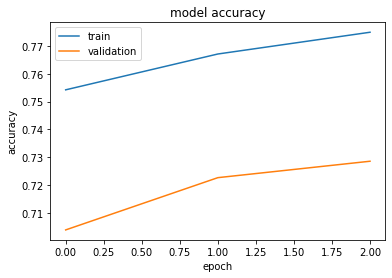

Fine Tuning Iteration: 3


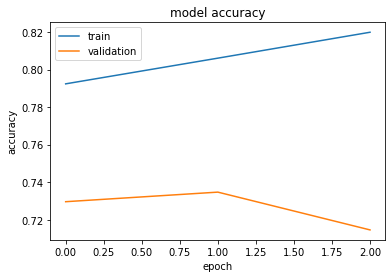

Fine Tuning Iteration: 4


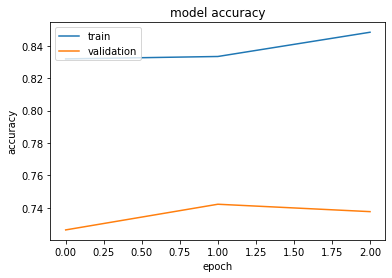

Fine Tuning Iteration: 5


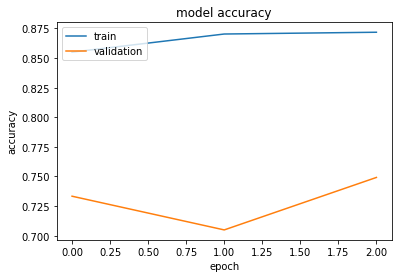

In [15]:
cntr = 2
for hist in histsVGG16:
  print("Fine Tuning Iteration:",cntr)
  cntr+=1
  plot_hist(hist)

### 7.4 Xception Fine Tune and Smaller Images

This sections model follows the exact same format as the model in section 7.2 but this time the image size is decreased to 256x256. The reason for this is when the fine tuning was attempted on the model in section 7.2, a resource exhaust error was produced.

In [ ]:
image_augment = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                    tf.keras.layers.RandomRotation(0.1),])

In [ ]:
from tensorflow.keras.applications import Xception
model = Xception(weights='imagenet', input_shape=(1024//4,1024//4,3), include_top=False)
#Freeze pretrained weigths
model.trainable = False
# Rebuild top
inputs = tf.keras.Input(shape=(1024//4,1024//4,3))
x = image_augment(inputs)
x = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(x)

x = model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(9)(x)
XceptionFineTune = tf.keras.Model(inputs, outputs)
XceptionFineTune.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

83683744/83683744 [==============================] - 1s 0us/step


#### 7.4.1 Xception Pre-Fine Tuning Model Summary

In [ ]:
XceptionFineTune.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                           

Using the same 0.3 test split as the rest of the notebook with a 256x256 image rescaling.

In [27]:
Xception_trainds, Xception_testds = splitImageData(data_dir, 1024//4, 1024//4, 0.3)

Found 12414 files belonging to 9 classes.
Using 8690 files for training.
Found 12414 files belonging to 9 classes.
Using 3724 files for validation.


In [ ]:
hist_XceptionFineTune = XceptionFineTune.fit(
  Xception_trainds,
  validation_data=Xception_testds,
  epochs=15
)

Epoch 1/15
272/272 [==============================] - 148s 519ms/step - loss: 1.3665 - accuracy: 0.5068 - val_loss: 1.2097 - val_accuracy: 0.5537
Epoch 2/15
272/272 [==============================] - 149s 538ms/step - loss: 1.2078 - accuracy: 0.5573 - val_loss: 1.1544 - val_accuracy: 0.5728
Epoch 3/15
272/272 [==============================] - 145s 523ms/step - loss: 1.1610 - accuracy: 0.5768 - val_loss: 1.1247 - val_accuracy: 0.5846
Epoch 4/15
272/272 [==============================] - 156s 566ms/step - loss: 1.1271 - accuracy: 0.5869 - val_loss: 1.1501 - val_accuracy: 0.5773
Epoch 5/15
272/272 [==============================] - 162s 583ms/step - loss: 1.1123 - accuracy: 0.5936 - val_loss: 1.1286 - val_accuracy: 0.5819
Epoch 6/15
272/272 [==============================] - 139s 502ms/step - loss: 1.0951 - accuracy: 0.5986 - val_loss: 1.0937 - val_accuracy: 0.5961
Epoch 7/15
272/272 [==============================] - 141s 509ms/step - loss: 1.0732 - accuracy: 0.6085 - val_loss: 1.0948 -

#### 7.4.2 Xception Pre-Fine Tuning Results

The results from the first 15 epochs of training only the post Xception model layers, resulted in accuracies very similar to the model in section 7.1 and section 7.2. 

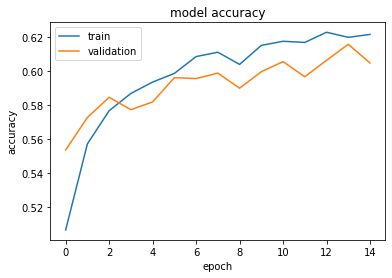

In [ ]:
plot_hist(hist_XceptionFineTune)

Saving pre-fine tuned weights so that they are not lost.

In [ ]:
XceptionFineTune.save("Xception_PreFineTune")
! cp -r Xception_PreFineTune "/content/gdrive/MyDrive/CS345Final/SavedModels"

#### 7.4.3 Xception Fine Tuning

In [ ]:
Xception_Model_load = tf.keras.models.load_model('/content/gdrive/MyDrive/CS345Final/SavedModels/Xception_PreFineTune')

Unfreezing the Xception model parameters. This can be confirmed in the model summary with theyre being 20,825,393 trainable paramters now.

In [ ]:
#UnFreeze pretrained weights in VGG16
for layer in Xception_Model_load.layers:
  if layer.name == "xception":
    layer.trainable = True
Xception_Model_load.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                           

Following the same strategy as the VGG16 fine tune model with using the adam optimizer with a very small learning rate of 1e-5.

In [ ]:
Xception_Model_load.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
hist_XceptionFineTune = Xception_Model_load.fit(
  Xception_trainds,
  validation_data=Xception_testds,
  epochs=5
)

Epoch 1/5
272/272 [==============================] - 296s 1s/step - loss: 0.9358 - accuracy: 0.6572 - val_loss: 0.9752 - val_accuracy: 0.6504
Epoch 2/5
272/272 [==============================] - 282s 1s/step - loss: 0.8418 - accuracy: 0.6936 - val_loss: 0.9229 - val_accuracy: 0.6711
Epoch 3/5
272/272 [==============================] - 292s 1s/step - loss: 0.7600 - accuracy: 0.7215 - val_loss: 0.8946 - val_accuracy: 0.6807
Epoch 4/5
272/272 [==============================] - 292s 1s/step - loss: 0.6972 - accuracy: 0.7479 - val_loss: 0.8679 - val_accuracy: 0.6917
Epoch 5/5
272/272 [==============================] - 288s 1s/step - loss: 0.6335 - accuracy: 0.7739 - val_loss: 0.8610 - val_accuracy: 0.6968


#### 7.4.4 Xception Fine Tuning 1 Results

The results of fine tuning the Xception model are very promising, showing accuracies on the test set to be slightly better than the previous VGG16 fine tuned model.

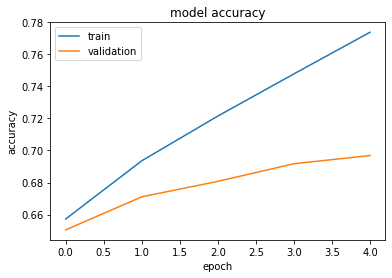

In [ ]:
plot_hist(hist_XceptionFineTune)

In [ ]:
Xception_Model_load.save("Xception_FineTune0")
! cp -r Xception_FineTune0 "/content/gdrive/MyDrive/CS345Final/SavedModels"

#### 7.4.5 Xception Fine Tuning 2 Results

The fine tuning continued to show promising results of increasing the testing set accuracy of the model.

In [ ]:
hist_XceptionFineTune2 = Xception_Model_load.fit(
  Xception_trainds,
  validation_data=Xception_testds,
  epochs=3
)

Epoch 1/3
272/272 [==============================] - 285s 1s/step - loss: 0.5787 - accuracy: 0.7888 - val_loss: 0.8261 - val_accuracy: 0.7108
Epoch 2/3
272/272 [==============================] - 284s 1s/step - loss: 0.5242 - accuracy: 0.8062 - val_loss: 0.8396 - val_accuracy: 0.7210
Epoch 3/3
272/272 [==============================] - 285s 1s/step - loss: 0.4781 - accuracy: 0.8237 - val_loss: 0.7991 - val_accuracy: 0.7282


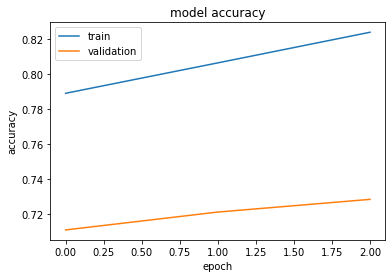

In [ ]:
plot_hist(hist_XceptionFineTune2)

In [ ]:
Xception_Model_load.save("Xception_FineTune1")
! cp -r Xception_FineTune1 "/content/gdrive/MyDrive/CS345Final/SavedModels"

#### 7.4.6 Xception Fine Tuning 3 Results

The testing set accuracy continued to increase but the validation set accuracy is increasing at a rate that is arguably overfitting.

In [ ]:
hist_XceptionFineTune3 = Xception_Model_load.fit(
  Xception_trainds,
  validation_data=Xception_testds,
  epochs=3
)

Epoch 1/3
272/272 [==============================] - 284s 1s/step - loss: 0.4332 - accuracy: 0.8436 - val_loss: 0.8504 - val_accuracy: 0.7280
Epoch 2/3
272/272 [==============================] - 283s 1s/step - loss: 0.3858 - accuracy: 0.8626 - val_loss: 0.8361 - val_accuracy: 0.7342
Epoch 3/3
272/272 [==============================] - 285s 1s/step - loss: 0.3473 - accuracy: 0.8712 - val_loss: 0.7986 - val_accuracy: 0.7409


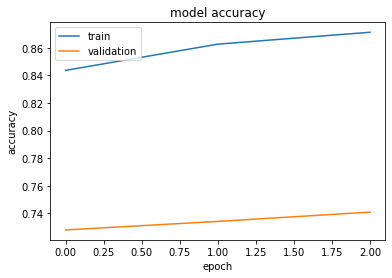

In [ ]:
plot_hist(hist_XceptionFineTune3)

In [ ]:
Xception_Model_load.save("Xception_FineTune2")
! cp -r Xception_FineTune2 "/content/gdrive/MyDrive/CS345Final/SavedModels"

#### 7.4.7 Final Fine Tuning for Xception Model

In [ ]:
import shutil
name = 'Xception_FineTune'

hists = []
for i in range(3,8):
  inp = input("Continue Fine Tuning? y/n: ")
  if (inp == 'n'):
    break
  print("Iteration",i)
  hist = Xception_Model_load.fit(
  Xception_trainds,
  validation_data=Xception_testds,
  epochs=3
  )
  hists.append(hist)
  folderName = name + str(i)
  Xception_Model_load.save(folderName)
  src = "/content/" + folderName
  dest = "/content/gdrive/MyDrive/CS345Final/SavedModels/" + folderName
  shutil.copytree(src, dest)


Continue Fine Tuning? y/n: y
Iteration 3
Epoch 1/3
272/272 [==============================] - 284s 1s/step - loss: 0.3149 - accuracy: 0.8860 - val_loss: 0.8321 - val_accuracy: 0.7427
Epoch 2/3
272/272 [==============================] - 284s 1s/step - loss: 0.2896 - accuracy: 0.8963 - val_loss: 0.8687 - val_accuracy: 0.7452
Epoch 3/3
272/272 [==============================] - 285s 1s/step - loss: 0.2498 - accuracy: 0.9081 - val_loss: 0.8853 - val_accuracy: 0.7479


Continue Fine Tuning? y/n: y
Iteration 4
Epoch 1/3
272/272 [==============================] - 326s 1s/step - loss: 0.2363 - accuracy: 0.9158 - val_loss: 0.8563 - val_accuracy: 0.7610
Epoch 2/3
272/272 [==============================] - 283s 1s/step - loss: 0.2111 - accuracy: 0.9246 - val_loss: 0.8789 - val_accuracy: 0.7594
Epoch 3/3
272/272 [==============================] - 284s 1s/step - loss: 0.1888 - accuracy: 0.9339 - val_loss: 0.8665 - val_accuracy: 0.7658


Continue Fine Tuning? y/n: y
Iteration 5
Epoch 1/3
272/272 [==============================] - 283s 1s/step - loss: 0.1791 - accuracy: 0.9376 - val_loss: 0.8203 - val_accuracy: 0.7736
Epoch 2/3
272/272 [==============================] - 286s 1s/step - loss: 0.1522 - accuracy: 0.9470 - val_loss: 0.8771 - val_accuracy: 0.7691
Epoch 3/3
272/272 [==============================] - 284s 1s/step - loss: 0.1404 - accuracy: 0.9525 - val_loss: 0.9184 - val_accuracy: 0.7704


Continue Fine Tuning? y/n: n


After performing an additional 9 epochs of fine tuning, the model reached a max accuracy of around 77%. The accuracy hardly decreased throughout the iterations which points to a model that might not have overfit. The difficult with arguing that point that the model was not over fit is becuase the validation accuracy is around 95%. The epochs were then stopped to try to prevent any future over fitting of the model.

Fine Tuning Iteration: 4


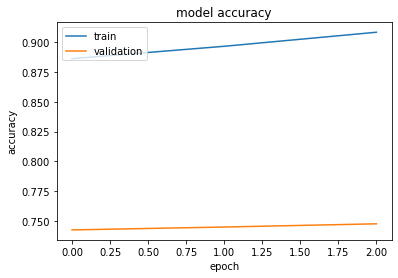

Fine Tuning Iteration: 5


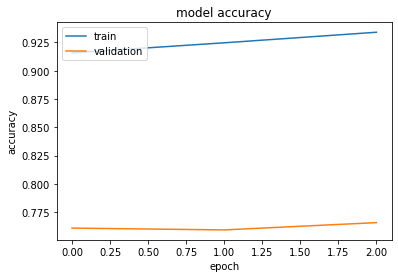

Fine Tuning Iteration: 6


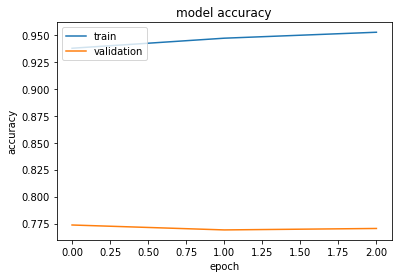

In [ ]:
cntr = 4
for hist in hists:
  print("Fine Tuning Iteration:",cntr)
  cntr+=1
  plot_hist(hist)

# **8. Analyze Fine Tuned Xception and VGG16 Model Accuracy and Confusion Matrix**

### 8.1 Xception Model Analysis
Load the last Xception model that performed the best accuracy.

In [28]:
Xception_Model_Confusion = tf.keras.models.load_model('/content/gdrive/MyDrive/CS345Final/SavedModels/Xception_FineTune5')

#### 8.1.1 Predict accuracy on the image test set for Xception

The prediction label is calculated by sotring the index of the prediction that had the largest value. The reason for this is the prediction method outputs a single dimensional vector of the probabilities that the image is each class. The class with the largest probability is chosen as the predicted label.

In [29]:
from tqdm import tqdm
cntr = 0
labels = []
pred = []
for img, label in tqdm(Xception_testds):
  pred.append(Xception_Model_Confusion.predict_on_batch(img))
  labels.append(label)

pred = np.concatenate(pred, axis = 0).argmax(axis = 1)
labels = np.concatenate(labels, axis = 0)

100%|██████████| 117/117 [00:57<00:00,  2.03it/s]


Calculate the accuracy of the Xception predictions to the labels

In [30]:
np.mean(pred == labels)

0.7704081632653061

Verify the calculated accuracy matches with the tf.keras built in evaluate method

In [31]:
test_accuracy = Xception_Model_Confusion.evaluate(Xception_testds)

117/117 [==============================] - 43s 339ms/step - loss: 0.9184 - accuracy: 0.7704


#### 8.1.2 Xception Confusion Matrix

In [32]:
confusion = tf.math.confusion_matrix(
    labels = labels,
    predictions = pred,
    num_classes = 9
)

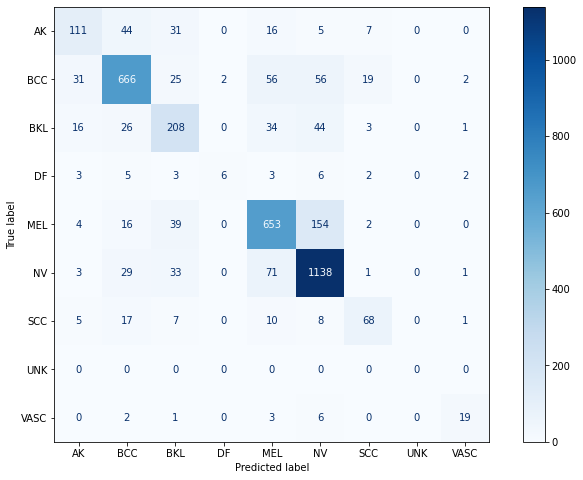

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay 
disp = ConfusionMatrixDisplay(confusion_matrix=confusion.numpy(), 
                              display_labels=Xception_testds.class_names)
fig, ax = plt.subplots(figsize=(12,8))
disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues);

In [42]:
skin_image_names = ["Actinic keratosis", "Basal Cell Carcinoma",
          "Benign Keratosis", "Dermatofibroma", 
          "Melanoma", "Melanocytic Nevus", 
          "Squamous Cell Carcinoma","None of the Above", "Vascular Lesion"]
acc_by_class_Xcep = {}
row_sums_Xcep = np.sum(confusion.numpy(), axis = 1);
#Acounting for the None of the Above Row
row_sums_Xcep[row_sums_Xcep == 0] = 1
for i in range(confusion.numpy().shape[0]):
  acc_by_class_Xcep[skin_image_names[i]] = confusion.numpy()[i,i]/row_sums_Xcep[i];

print("Accuracies:")
for key in acc_by_class_Xcep:
  print(key, "Accuracy:",round(acc_by_class_Xcep[key]*100,3))

Accuracies:
Actinic keratosis Accuracy: 51.869
Basal Cell Carcinoma Accuracy: 77.713
Benign Keratosis Accuracy: 62.651
Dermatofibroma Accuracy: 20.0
Melanoma Accuracy: 75.23
Melanocytic Nevus Accuracy: 89.185
Squamous Cell Carcinoma Accuracy: 58.621
None of the Above Accuracy: 0.0
Vascular Lesion Accuracy: 61.29


#### 8.1.3 Xception Model Results Analysis

Looking at the above confusion matrix and the resulting accuracies by class, the confusion matrix shows that the neural network had the hardest time accuratly predicting a Dermatofibroma lesion. For the DF lesion the neural network was confused on the type and had a close to even distribution of guesses of other skin lesions.. According to the confusion matrix it was a common trend for the model to predict either Melanocytic Nevus and Melanoma. What this possibly points to is the model needing a better distribution of the 6 other skin lesion types to learn on so that the accuracy can be improved for those specific skin lesion types. More specifically different techinqiues need to be researched and aplied or more examples of the lacking image classification images need to be provided. Additionally it looks like the model slowly really closely learned to adjust to Melanocytic Nevus lesions. This is unsurprising because the model was provided the most Melanocytic Nevus skin lesion images out of the other skin lesions. Lastly an unsurprising results showed that the model never predicted a skin lesion to be none of the above. This is unsurprising as the model trained on images that did not contain images of none of the above examples. 

The overall accuracy ended up to be around 77%. This is much better than what was seen in the CNN models (around 54%) as well as the pre-fine tuned Xception (around 65%) models. This accuracy definitely has room to improve. A possible way to improve the accuracy would be making use of the meta data that was included in the dataset. Addtionally what wasnt tested was using the Xception model transfer learning into a more complex neural network. Lastly as stated above, the most could improve by being provided more examples of the skin lesions that lacked in accuracy.

### 8.2 VGG16 Model Analysis

In [35]:
VGG16_Model_Confusion = tf.keras.models.load_model('/content/gdrive/MyDrive/CS345Final/SavedModels/VGG16_FineTune5')

#### 8.2.1 Predict Accuarcy on the image test set for VGG16

In [36]:
from tqdm import tqdm
cntr = 0
vgg16_labels = []
vgg16_pred = []
for img, label in tqdm(vgg16_testds):
  vgg16_pred.append(VGG16_Model_Confusion.predict_on_batch(img))
  vgg16_labels.append(label)

vgg16_pred = np.concatenate(vgg16_pred, axis = 0).argmax(axis = 1)
vgg16_labels = np.concatenate(vgg16_labels, axis = 0)

100%|██████████| 117/117 [01:21<00:00,  1.43it/s]


In [37]:
np.mean(vgg16_pred == vgg16_labels)

0.7491944146079484

In [38]:
vgg16test_accuracy = VGG16_Model_Confusion.evaluate(vgg16_testds)

117/117 [==============================] - 37s 293ms/step - loss: 0.8787 - accuracy: 0.7492


#### 8.2.2 VGG16 Confusion Matrix

In [39]:
vgg16confusion = tf.math.confusion_matrix(
    labels = vgg16_labels,
    predictions = vgg16_pred,
    num_classes = 9
)

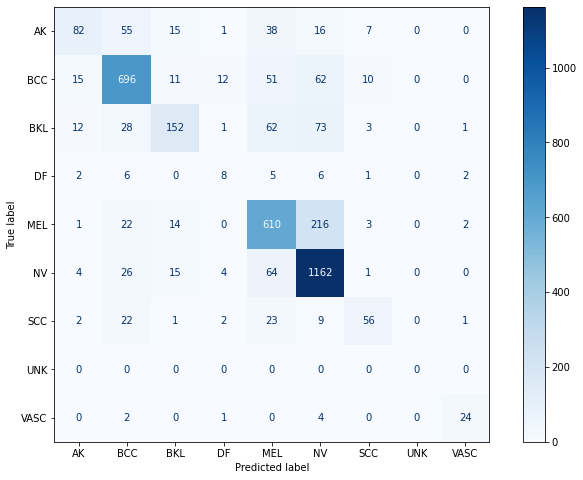

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay 
disp = ConfusionMatrixDisplay(confusion_matrix=vgg16confusion.numpy(), 
                              display_labels=vgg16_testds.class_names)
fig, ax = plt.subplots(figsize=(12,8))
disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues);

In [43]:
skin_image_names = ["Actinic keratosis", "Basal Cell Carcinoma",
          "Benign Keratosis", "Dermatofibroma", 
          "Melanoma", "Melanocytic Nevus", 
          "Squamous Cell Carcinoma","None of the Above", "Vascular Lesion"]
acc_by_class_vgg = {}
row_sums_vgg = np.sum(vgg16confusion.numpy(), axis = 1);
#Acounting for the None of the Above Row
row_sums_vgg[row_sums_vgg == 0] = 1
for i in range(vgg16confusion.numpy().shape[0]):
  acc_by_class_vgg[skin_image_names[i]] = vgg16confusion.numpy()[i,i]/row_sums_vgg[i];

print("Accuracies:")
for key in acc_by_class_vgg:
  print(key, "Accuracy:",round(acc_by_class_vgg[key]*100,3))

Accuracies:
Actinic keratosis Accuracy: 38.318
Basal Cell Carcinoma Accuracy: 81.214
Benign Keratosis Accuracy: 45.783
Dermatofibroma Accuracy: 26.667
Melanoma Accuracy: 70.276
Melanocytic Nevus Accuracy: 91.066
Squamous Cell Carcinoma Accuracy: 48.276
None of the Above Accuracy: 0.0
Vascular Lesion Accuracy: 77.419


#### 8.2.3 VGG16 Model Results Analysis

The above confusion matrix shows that the the transfer learning model using VGG 16 struggled particularly with predicting Dermatofibroma. This is similar to the Xception transfer learning model. When looking at the dataset provided, post image processing, the dataset only contained 124 dermatofibroma images in comparison to 4,206  malanocytic nevus images. Additionally the VGG16 model showed even better accuracy for the melanocytic nevus skin lesions. This points to the model training too specifically towards improving accuracy on the Melanocytic Nevus images, by the model overtraining on this specific class, the accuracy of Actinic Keratosis, Benign Keratosis, Dermatofibroma, and Squamous Cell Carcinoma, severly lacked in performance.

Overall the accuracy of the VGG16 transfer learning model was around 74.9%. This was worse than the Xception transfer learning model but performed better than all the other models in this notebook. As stated in the Xception model, possible future improvements would be to utilize the dataset metadata, provide more images for the underperforming classifications, and possibly try more complex neural networks post the VGG16 model layer.

# **9. Final Thoughts**

The best performing model in the notebook ended up being the Xception transfer learning model that was fine tuned. The accuracy performed by this model was around 77%. This model did a slightly better job at predicting the skin lesion classes that were under represented in the dataset, but the performance definitely needs to improved, where accuracies as low as 20% were seen trying to predict Dermatofibroma images. Lastly the model showed to almost double the baseline neural network in section 6.1. This shows that the model was detecting patterns in the images to make classifications on. Unfortuanetly these patterns could partly be to overfitting the Malanocytic Nevus accuracy which showed much higher accuracies than the other classifications.

**Future Improvements**
Some future improvements to entail to see if model performance is improved is listed below:

*   Improving the image dataset for the model so that there are more images for the underrepresented classes.
*   Creating more complex models past the transfer training from the Xception model
*   Researching and employing techniques to help with the model to not overfit to one specific class.
*   Utilizing the included metadata dataset in addition to the images with the skin lesion classifications
*   Research and employ techniques that allow using all the images in the dataset instead of specifically the 1024x1024 images.

# **10. Sources**

Below are a list of the sources used on this doucment.

**Textbooks:**

Dive into Deep Learning:
https://d2l.ai/index.html


Raschka, & Mirajalili, V. (2017). Python machine learning : machine learning and deep learning with Python, scikit-learn, and TensorFlow (Second edition.). Packt Publishing.

**TensorFlow/Keras API Documentation:**

https://www.tensorflow.org/tutorials/load_data/images

https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

https://www.tensorflow.org/guide/keras/transfer_learning

https://keras.io/guides/transfer_learning/

https://www.tensorflow.org/guide/keras/train_and_evaluate

https://www.tensorflow.org/tutorials/keras/classification

https://www.tensorflow.org/api_docs/python/tf/keras/Model

https://www.tensorflow.org/api_docs/python/tf/data/Dataset

https://www.tensorflow.org/tutorials/images/data_augmentation

https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/Xception

https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

https://keras.io/api/layers/pooling_layers/max_pooling2d/

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

https://keras.io/api/optimizers/

https://keras.io/api/applications/

https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix

**CS345 Github Notebooks:**

https://github.com/asabenhur/CS345/blob/master/fall22/notebooks/module05_04_classifier_accuracy.ipynb

**Machine Learning Blogs:**

https://towardsdatascience.com/4-pre-trained-cnn-models-to-use-for-computer-vision-with-transfer-learning-885cb1b2dfc

https://towardsdatascience.com/medical-x-ray-%EF%B8%8F-image-classification-using-convolutional-neural-network-9a6d33b1c2a

